In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

C:\Users\Javi\Anaconda3\envs\crypto-env\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Javi\Anaconda3\envs\crypto-env\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Javi\Anaconda3\envs\crypto-env\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Javi\Anaconda3\envs\crypto-env\lib\site-packages\ten

In [2]:
data = pd.read_csv('C:/Users/Javi/Desktop/cryptocurrency_predictor/data/hourly_features.csv',
                   parse_dates=True,
                   index_col='date')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 677 entries, 2021-02-21 00:00:00 to 2021-03-20 23:00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   close        677 non-null    float64
 1   volume       677 non-null    float64
 2   g_trends     677 non-null    int64  
 3   vader_score  677 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 26.4 KB


,close,volume,g_trends,vader_score
date,,,,
2021-02-21 00:00:00,55834.95,2949.777561,72,154319.02855
2021-02-21 01:00:00,56347.69,2125.263288,72,102026.76434
2021-02-21 02:00:00,56318.08,2201.031649,72,182005.34381
2021-02-21 03:00:00,56505.22,2027.220197,73,62987.43980
2021-02-21 04:00:00,56701.08,2060.642337,75,117490.73592


In [3]:
dates = pd.to_datetime(data.index)
df = data.reset_index(drop=True).astype(float)
print(dates.shape, df.shape)
print()
n_features = len(df.columns)
print('Number of features for forecasting: %i' %n_features)

(677,) (677, 4)

Number of features for forecasting: 4


In [4]:
# LSTM uses sigmoid and tanh which are sensitive to magnitude so large values need to be scaled
scaler = MinMaxScaler().fit(df)
df_scaled = scaler.transform(df)
print(df_scaled.shape)
df_scaled

(677, 4)


array([[0.6862629 , 0.09008433, 0.56923077, 0.51637072],
       [0.71393484, 0.05523493, 0.56923077, 0.50137732],
       [0.71233683, 0.0584374 , 0.56923077, 0.52430903],
       ...,
       [0.84243822, 0.00496498, 0.44615385, 0.53214178],
       [0.83025478, 0.01452938, 0.44615385, 0.55932585],
       [0.80862788, 0.06030149, 0.46153846, 0.51551712]])

In [5]:
# We cannot split data into training and test sets randomly as the sequence of events is important for timme series.
train_size = int(0.85 * len(df_scaled))
test_size = len(df_scaled) - train_size
train, test = df_scaled[:train_size], df_scaled[-test_size:]

In [6]:
train.shape, test.shape

((575, 4), (102, 4))

In [7]:
def to_sequences(df, n_past, n_future):
    """
    Returns X, y as numpy arrays, ready to fit into the model.
    X has the input shape [samples, time steps, features]
    y has the output shape, it returns only the first column: close price.
    
    Parameters
    ----------
    df : data for study. type() == np.array
    n_past : Number of past periods we want to use to predict
    n_future : Number of periods we want to predict into the future
    """
    X = []
    y = []
    for i in range(n_past, len(df) - n_future + 1):
        X.append(df[i - n_past:i, 0:df.shape[1]])
        y.append(df[i + n_future - 1:i + n_future, 0])
    
    return np.array(X), np.array(y)

In [8]:
n_past = 12
n_future = 1

X_train, y_train = to_sequences(train, n_past, n_future)
X_test, y_test = to_sequences(test, n_past, n_future)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(563, 12, 4) (563, 1)
(90, 12, 4) (90, 1)


### Building the model

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 64)            17664     
_________________________________________________________________
dropout (Dropout)            (None, 12, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________


Epoch 62/100
563/563 [==============================] - 1s 1ms/sample - loss: 0.0035 - val_loss: 0.0046
Epoch 63/100
563/563 [==============================] - 1s 1ms/sample - loss: 0.0035 - val_loss: 0.0023
Epoch 64/100
563/563 [==============================] - ETA: 0s - loss: 0.003 - 1s 1ms/sample - loss: 0.0033 - val_loss: 0.0025
Epoch 65/100
563/563 [==============================] - 1s 1ms/sample - loss: 0.0036 - val_loss: 0.0024
Epoch 66/100
563/563 [==============================] - 1s 1ms/sample - loss: 0.0038 - val_loss: 0.0027
Epoch 67/100
563/563 [==============================] - 1s 1ms/sample - loss: 0.0037 - val_loss: 0.0029
Epoch 68/100
563/563 [==============================] - 1s 1ms/sample - loss: 0.0030 - val_loss: 0.0042
Epoch 69/100
563/563 [==============================] - 1s 1ms/sample - loss: 0.0032 - val_loss: 0.0024
Epoch 70/100
563/563 [==============================] - 1s 1ms/sample - loss: 0.0030 - val_loss: 0.0036
Epoch 71/100
563/563 [==================

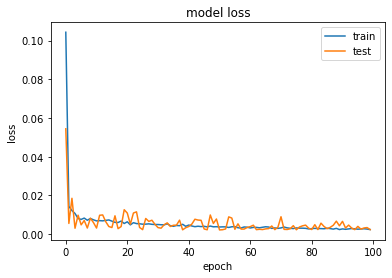

In [9]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=16, verbose=1)

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [10]:
def inverse_scale(data_to_inverse, n_features, scaler, column=0):
    """Inverts scaled data to its original values
    
    Parameters
    ----------
    scaler : scaler used for the first inversion.
    data_to_inverse : np.array to inverse.
    n_features : Columns to repeat.
    column : Column to return as a vector.
        Default, first column, as closing price is.
    """
    copy = np.repeat(data_to_inverse, n_features, 1)
    
    return scaler.inverse_transform(copy)[:, column]

In [11]:
train_dates = dates[:y_train.shape[0]]
test_dates = dates[-y_test.shape[0]:]

# Make predictions
train_predict_scaled = model.predict(X_train)
test_predict_scaled = model.predict(X_test)

# Now we need to inverse MinMaxScaler on our forecats.
# Since we used 4 variables to scale it, we will need that same shape to rescale [x, 4]
# We can just copy our values 4 times with np.repeat

train_predict = inverse_scale(train_predict_scaled, n_features, scaler)
test_predict = inverse_scale(test_predict_scaled, n_features, scaler)

y_train = inverse_scale(y_train, n_features, scaler)
y_test = inverse_scale(y_test, n_features, scaler)

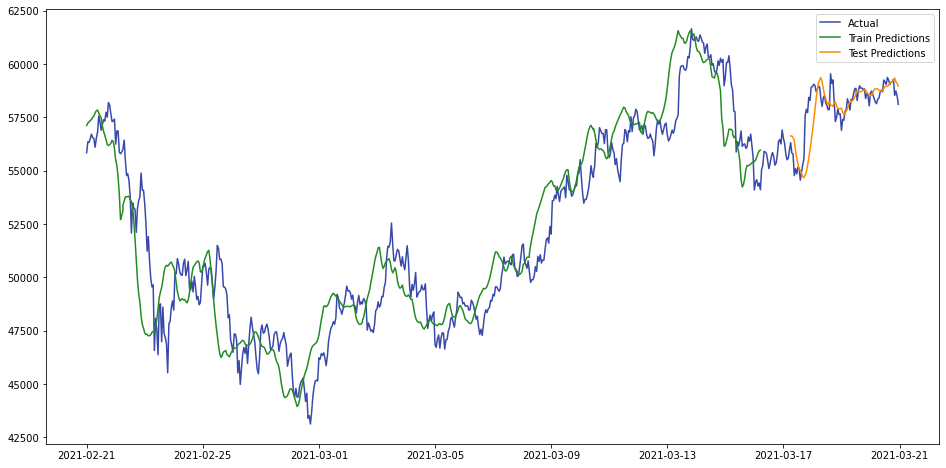

In [12]:
plt.figure(figsize=(16, 8))
plt.plot(dates, df['close'], label='Actual', color='#3949AB')
plt.plot(train_dates, train_predict, label='Train Predictions', color='forestgreen')
plt.plot(test_dates, test_predict, label='Test Predictions', color='darkorange')
plt.legend()

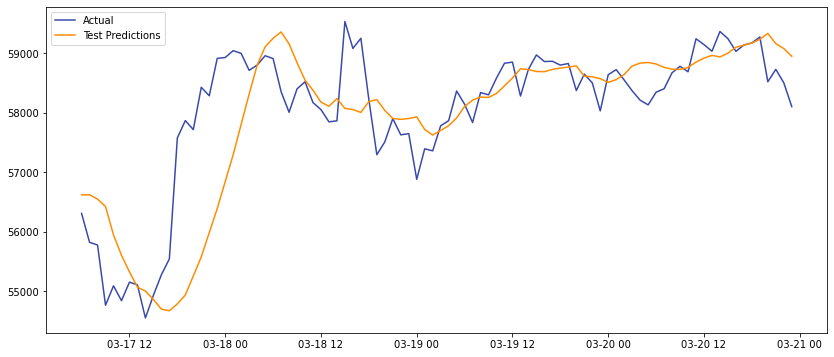

In [13]:
plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test, label='Actual', color='#3949AB')
plt.plot(test_dates, test_predict, label='Test Predictions', color='darkorange')
plt.legend()

In [14]:
# Calculate root mean squared error
# train_score = math.sqrt(mean_squared_error(df['close'][:-100], train_predict[:, 0]))
train_score = math.sqrt(mean_squared_error(y_train, train_predict))
test_score = math.sqrt(mean_squared_error(y_test, test_predict))

print('Train Score: %.2f RMSE' %train_score)
print('Test Score: %.2f RMSE' %test_score)

Train Score: 625.88 RMSE
Test Score: 903.68 RMSE
